In [2]:
"""
Satellite Image Data Analysis Pipeline for Wildfire Risk Assessment
Industry-Standard Code for the WIFIRE Project

Author: Geo-Spatial Analytics Team
Date: 2024-12-19
Version: 1.0.0
"""

# Standard Library Imports
import warnings
from typing import Tuple, Optional
from pathlib import Path

# Third-Party Imports
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy import ndimage
from sklearn.preprocessing import StandardScaler

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


class SatelliteImageProcessor:
    """
    A professional-grade processor for multi-channel satellite imagery
    specifically designed for topographic feature analysis in wildfire monitoring.
    """

    # Class constants for channel mapping
    CHANNEL_RED: int = 0  # Represents Altitude
    CHANNEL_GREEN: int = 1  # Represents Slope
    CHANNEL_BLUE: int = 2  # Represents Aspect

    def __init__(self, image_path: str) -> None:
        """
        Initialize the satellite image processor.

        Args:
            image_path (str): Path to the satellite image file
        """
        self.image_path: Path = Path(image_path)
        self.image_data: np.ndarray = None
        self.image_metadata: dict = {}
        self._load_image()

    def _load_image(self) -> None:
        """
        Load satellite image and validate its structure.
        """
        try:
            # Load image using scikit-image's robust IO module
            self.image_data = io.imread(self.image_path)

            # Validate image dimensions
            if self.image_data.ndim != 3 or self.image_data.shape[2] != 3:
                raise ValueError("Image must be 3-channel RGB format")

            self._update_metadata()
            print(f"✓ Successfully loaded image: {self.image_path.name}")

        except FileNotFoundError:
            raise FileNotFoundError(f"Image file not found: {self.image_path}")
        except Exception as e:
            raise RuntimeError(f"Failed to load image: {str(e)}")

    def _update_metadata(self) -> None:
        """
        Update metadata dictionary with current image properties.
        """
        self.image_metadata = {
            'shape': self.image_data.shape,
            'dtype': self.image_data.dtype,
            'min_value': np.min(self.image_data),
            'max_value': np.max(self.image_data),
            'mean_value': np.mean(self.image_data),
            'size_mb': self.image_data.nbytes / (1024 * 1024)
        }

    def display_image(self,
                      figsize: Tuple[int, int] = (12, 10),
                      title: str = "Satellite Image Overview",
                      save_path: Optional[str] = None) -> None:
        """
        Display the loaded satellite image with professional formatting.

        Args:
            figsize (Tuple): Figure dimensions (width, height) in inches
            title (str): Plot title
            save_path (str): Optional path to save the figure
        """
        plt.figure(figsize=figsize)
        plt.imshow(self.image_data)
        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.colorbar(label='Pixel Intensity')
        plt.axis('off')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Figure saved to: {save_path}")

        plt.show()

    def get_pixel_value(self, row: int, col: int, channel: Optional[int] = None) -> np.ndarray:
        """
        Retrieve pixel value(s) at specified coordinates.

        Args:
            row (int): Row index (0-based)
            col (int): Column index (0-based)
            channel (int, optional): Specific channel to retrieve

        Returns:
            np.ndarray: Pixel value(s)
        """
        self._validate_coordinates(row, col)

        if channel is not None:
            self._validate_channel(channel)
            return self.image_data[row, col, channel]
        else:
            return self.image_data[row, col]

    def apply_pixel_operation(self,
                              row: int,
                              col: int,
                              new_value: np.ndarray) -> None:
        """
        Modify pixel value at specified coordinates.

        Args:
            row (int): Row index
            col (int): Column index
            new_value (np.ndarray): New RGB values [R, G, B]
        """
        self._validate_coordinates(row, col)
        self.image_data[row, col] = new_value
        print(f"✓ Pixel at ({row}, {col}) updated to {new_value}")

    def apply_region_operation(self,
                               row_start: int,
                               row_end: int,
                               col_start: int,
                               col_end: int,
                               operation: str,
                               value: int = 255) -> None:
        """
        Apply operation to a rectangular region of the image.

        Args:
            row_start (int): Start row index
            row_end (int): End row index (exclusive)
            col_start (int): Start column index
            col_end (int): End column index (exclusive)
            operation (str): Operation type ('set', 'add', 'multiply')
            value (int): Value for the operation
        """
        # Create slice objects for cleaner indexing
        row_slice = slice(row_start, row_end)
        col_slice = slice(col_start, col_end)

        region = self.image_data[row_slice, col_slice]

        if operation == 'set':
            region[:] = value
        elif operation == 'add':
            region[:] = np.clip(region + value, 0, 255)
        elif operation == 'multiply':
            region[:] = np.clip(region * value, 0, 255)
        else:
            raise ValueError("Operation must be 'set', 'add', or 'multiply'")

        print(f"✓ Applied {operation} operation to region {row_start}:{row_end}, {col_start}:{col_end}")

    def create_circular_mask(self,
                             center: Optional[Tuple[int, int]] = None,
                             radius: Optional[float] = None) -> np.ndarray:
        """
        Create a boolean circular mask for image processing.

        Args:
            center (Tuple): Center coordinates (row, col)
            radius (float): Radius of the circle

        Returns:
            np.ndarray: Boolean mask array
        """
        height, width, _ = self.image_data.shape

        # Set default center to image center if not provided
        if center is None:
            center = (height // 2, width // 2)

        # Set default radius to 40% of image height if not provided
        if radius is None:
            radius = height * 0.4

        # Create coordinate grids
        y_coords, x_coords = np.ogrid[:height, :width]

        # Calculate distance from center for each pixel
        distance_from_center = np.sqrt((x_coords - center[1]) ** 2 +
                                       (y_coords - center[0]) ** 2)

        # Create boolean mask
        mask = distance_from_center <= radius
        return mask

    def apply_mask(self,
                   mask: np.ndarray,
                   operation: str = 'zero',
                   value: int = 0) -> None:
        """
        Apply a boolean mask to the image.

        Args:
            mask (np.ndarray): Boolean mask array
            operation (str): Operation to perform ('zero', 'set', 'highlight')
            value (int): Value for set operation
        """
        if operation == 'zero':
            self.image_data[mask] = 0
        elif operation == 'set':
            self.image_data[mask] = value
        elif operation == 'highlight':
            self.image_data[mask] = 255
        else:
            raise ValueError("Operation must be 'zero', 'set', or 'highlight'")

    def analyze_topographic_feature(self,
                                    feature: str,
                                    threshold: int = 150) -> np.ndarray:
        """
        Analyze specific topographic feature based on channel mapping.

        Args:
            feature (str): Feature to analyze ('altitude', 'slope', 'aspect')
            threshold (int): Intensity threshold for feature detection

        Returns:
            np.ndarray: Feature mask
        """
        # Map feature names to channel indices
        feature_channel_map = {
            'altitude': self.CHANNEL_RED,
            'slope': self.CHANNEL_GREEN,
            'aspect': self.CHANNEL_BLUE
        }

        if feature not in feature_channel_map:
            raise ValueError("Feature must be 'altitude', 'slope', or 'aspect'")

        channel_idx = feature_channel_map[feature]

        # Create mask for high-intensity pixels in the specified channel
        feature_mask = self.image_data[:, :, channel_idx] > threshold

        # Apply mask to highlight the feature
        temp_image = self.image_data.copy()
        temp_image[~feature_mask] = 0  # Set non-feature pixels to zero

        # Display results
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(temp_image)
        plt.title(f'Highlighted {feature.capitalize()} (Threshold: {threshold})',
                  fontweight='bold')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.hist(self.image_data[:, :, channel_idx].flatten(),
                 bins=50, alpha=0.7, color='blue')
        plt.axvline(threshold, color='red', linestyle='--',
                    label=f'Threshold: {threshold}')
        plt.title(f'{feature.capitalize()} Intensity Distribution')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()

        plt.tight_layout()
        plt.show()

        return feature_mask

    def generate_composite_analysis(self,
                                    thresholds: dict = None) -> None:
        """
        Generate composite analysis of multiple topographic features.

        Args:
            thresholds (dict): Dictionary of thresholds for each feature
        """
        # Default thresholds if none provided
        if thresholds is None:
            thresholds = {
                'altitude': 100,
                'slope': 120,
                'aspect': 80
            }

        # Create individual feature masks
        altitude_mask = self.image_data[:, :, self.CHANNEL_RED] > thresholds['altitude']
        slope_mask = self.image_data[:, :, self.CHANNEL_GREEN] > thresholds['slope']
        aspect_mask = self.image_data[:, :, self.CHANNEL_BLUE] > thresholds['aspect']

        # Create composite mask using logical AND
        composite_mask = np.logical_and.reduce([altitude_mask, slope_mask, aspect_mask])

        # Apply composite mask
        composite_image = self.image_data.copy()
        composite_image[~composite_mask] = 0

        # Display composite analysis
        plt.figure(figsize=(15, 10))

        # Original image
        plt.subplot(2, 2, 1)
        plt.imshow(self.image_data)
        plt.title('Original Satellite Image', fontweight='bold')
        plt.axis('off')

        # Individual feature masks
        plt.subplot(2, 2, 2)
        plt.imshow(composite_image)
        plt.title('Composite Feature Analysis', fontweight='bold')
        plt.axis('off')

        # Threshold settings
        plt.subplot(2, 2, 3)
        features = list(thresholds.keys())
        values = list(thresholds.values())
        colors = ['red', 'green', 'blue']

        plt.bar(features, values, color=colors, alpha=0.7)
        plt.title('Analysis Threshold Settings', fontweight='bold')
        plt.ylabel('Intensity Threshold')

        # Mask statistics
        plt.subplot(2, 2, 4)
        mask_sizes = [np.sum(altitude_mask), np.sum(slope_mask), np.sum(aspect_mask), np.sum(composite_mask)]
        mask_labels = ['Altitude', 'Slope', 'Aspect', 'Composite']

        plt.bar(mask_labels, mask_sizes, color=['red', 'green', 'blue', 'purple'], alpha=0.7)
        plt.title('Feature Pixel Counts', fontweight='bold')
        plt.ylabel('Number of Pixels')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    def _validate_coordinates(self, row: int, col: int) -> None:
        """
        Validate that coordinates are within image bounds.

        Args:
            row (int): Row index
            col (int): Column index
        """
        height, width, _ = self.image_data.shape
        if not (0 <= row < height and 0 <= col < width):
            raise IndexError(f"Coordinates ({row}, {col}) are out of bounds for image shape {self.image_data.shape}")

    def _validate_channel(self, channel: int) -> None:
        """
        Validate that channel index is valid.

        Args:
            channel (int): Channel index
        """
        if channel not in [0, 1, 2]:
            raise ValueError("Channel must be 0 (Red), 1 (Green), or 2 (Blue)")

    def save_processed_image(self, output_path: str) -> None:
        """
        Save the processed image to file.

        Args:
            output_path (str): Path to save the processed image
        """
        try:
            io.imsave(output_path, self.image_data)
            print(f"✓ Processed image saved to: {output_path}")
        except Exception as e:
            raise RuntimeError(f"Failed to save image: {str(e)}")

    def __repr__(self) -> str:
        """
        Return string representation of the processor.
        """
        return (f"SatelliteImageProcessor(image_path='{self.image_path}', "
                f"shape={self.image_data.shape}, dtype={self.image_data.dtype})")



In [3]:
processor = SatelliteImageProcessor('sd-3layers.jpg')

✓ Successfully loaded image: sd-3layers.jpg


In [5]:
# Display basic image information
print("\n" + "=" * 60)
print("SATELLITE IMAGE PROCESSING PIPELINE")
print("=" * 60)
print(f"Image Shape: {processor.image_metadata['shape']}")
print(f"Data Type: {processor.image_metadata['dtype']}")
print(f"Value Range: [{processor.image_metadata['min_value']}, {processor.image_metadata['max_value']}]")
print(f"File Size: {processor.image_metadata['size_mb']:.2f} MB")


SATELLITE IMAGE PROCESSING PIPELINE
Image Shape: (3725, 4797, 3)
Data Type: uint8
Value Range: [0, 255]
File Size: 51.12 MB


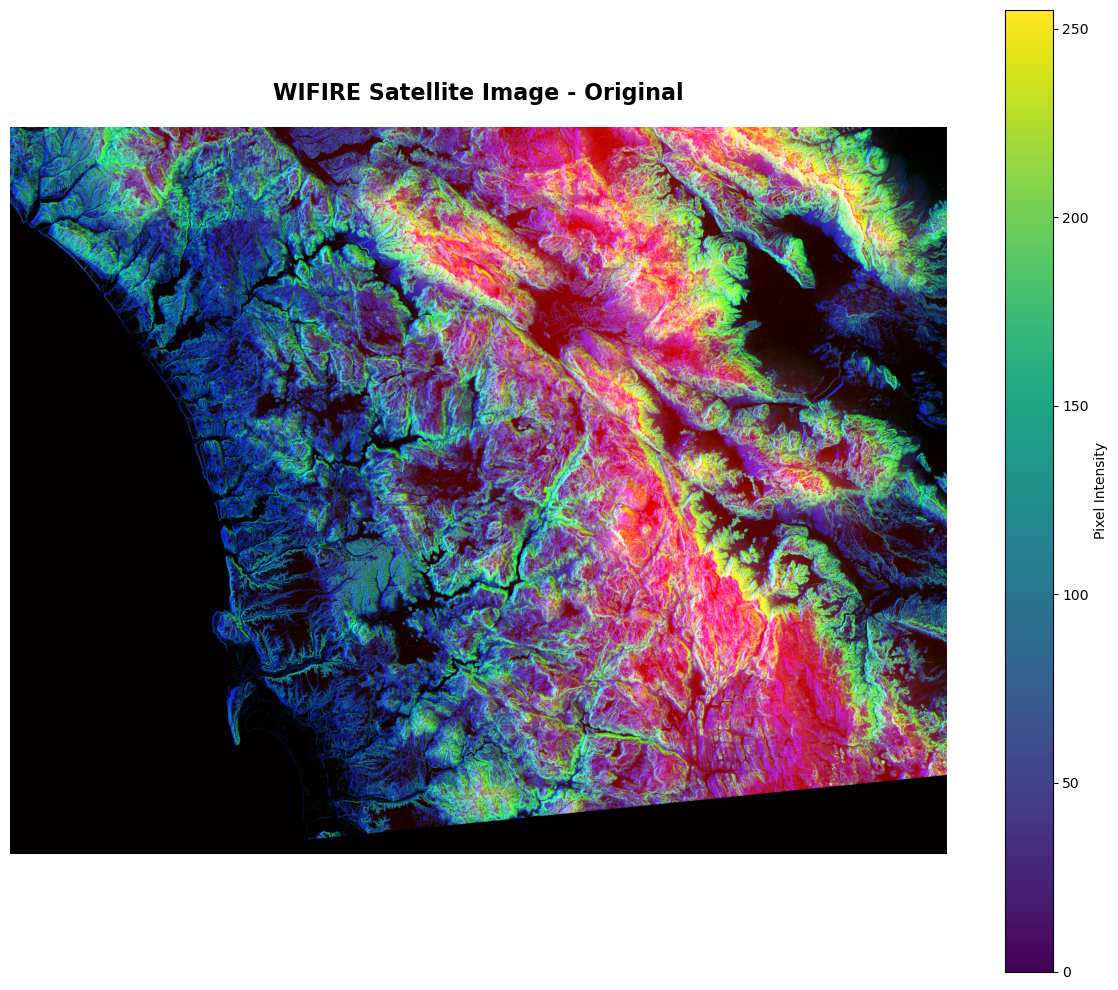

In [6]:
# Display original image
processor.display_image(title="WIFIRE Satellite Image - Original")


Analyzing topographic features...


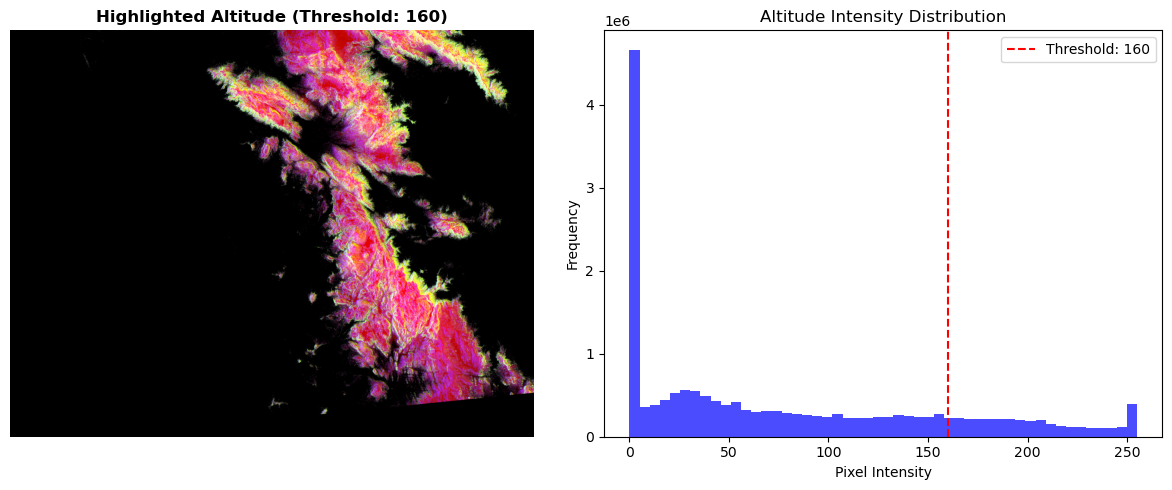

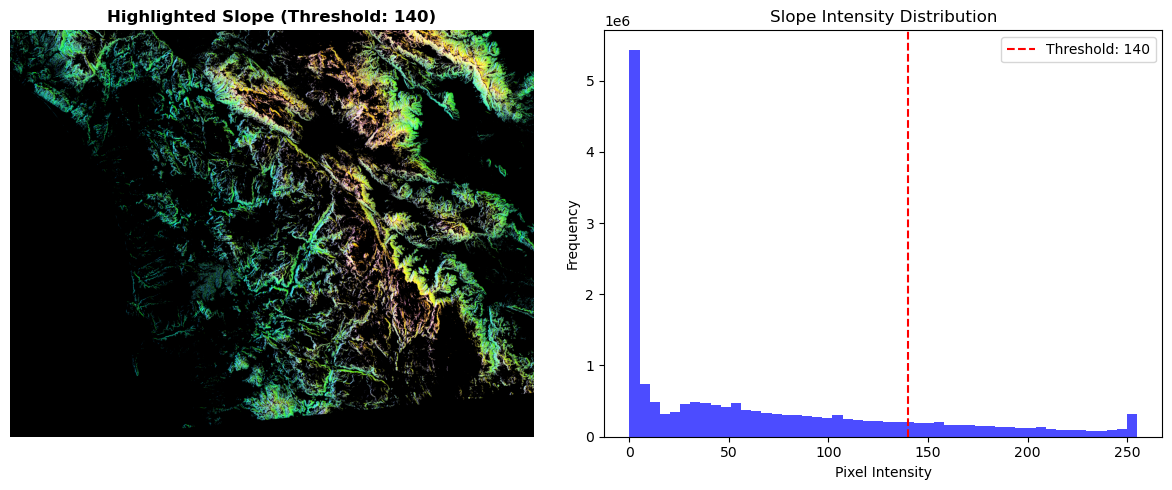

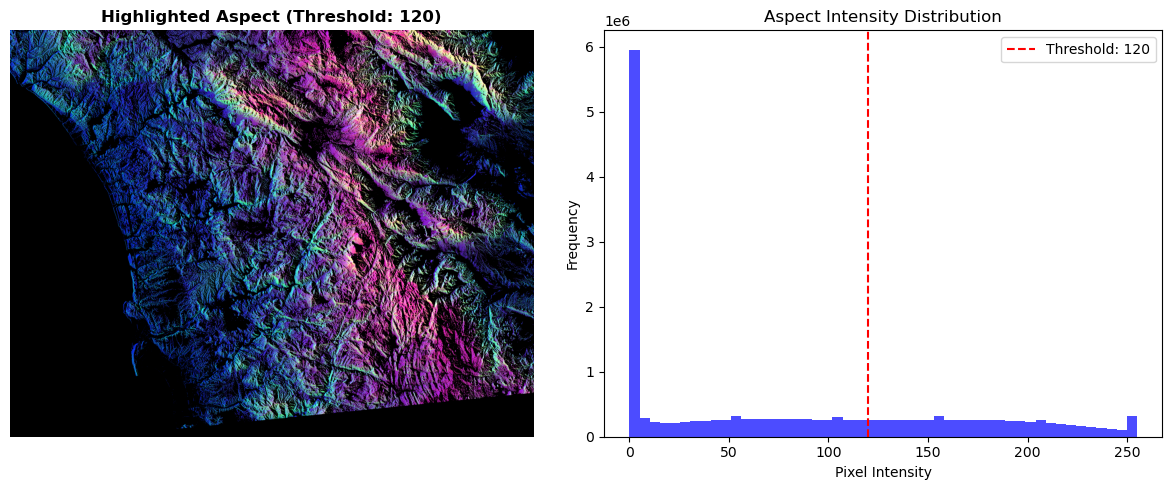

array([[False, False,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [7]:
# Analyze individual topographic features
print("\nAnalyzing topographic features...")
processor.analyze_topographic_feature('altitude', threshold=160)
processor.analyze_topographic_feature('slope', threshold=140)
processor.analyze_topographic_feature('aspect', threshold=120)


Performing composite analysis...


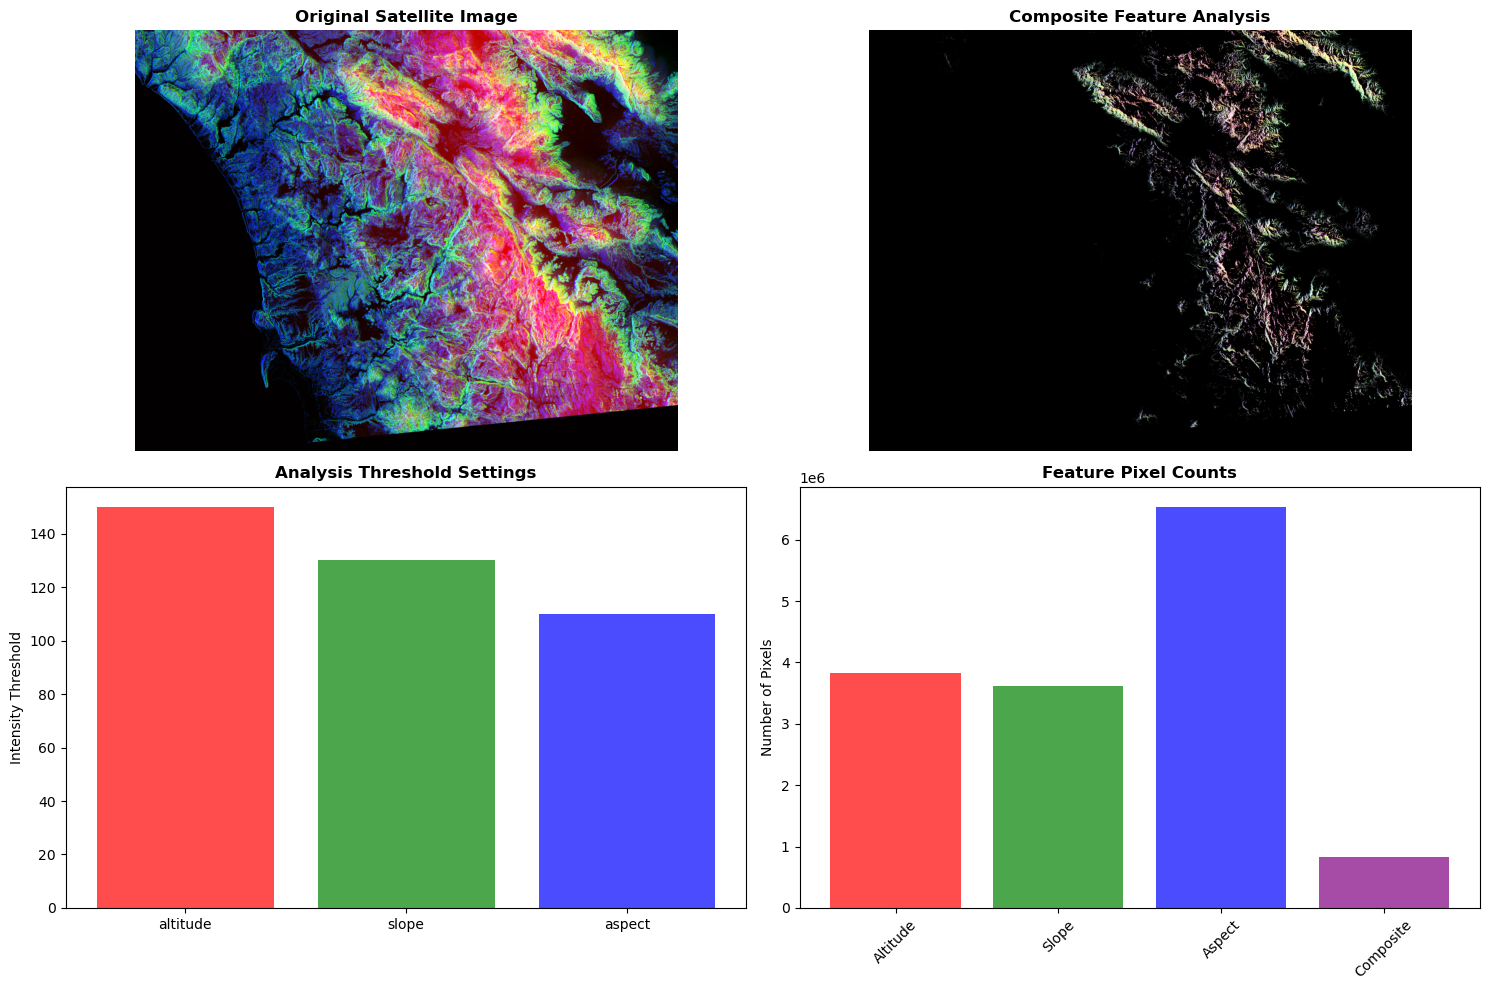

In [8]:
# Perform composite analysis
print("\nPerforming composite analysis...")
composite_thresholds = {
    'altitude': 150,
    'slope': 130,
    'aspect': 110
}
processor.generate_composite_analysis(composite_thresholds)


Creating circular mask...


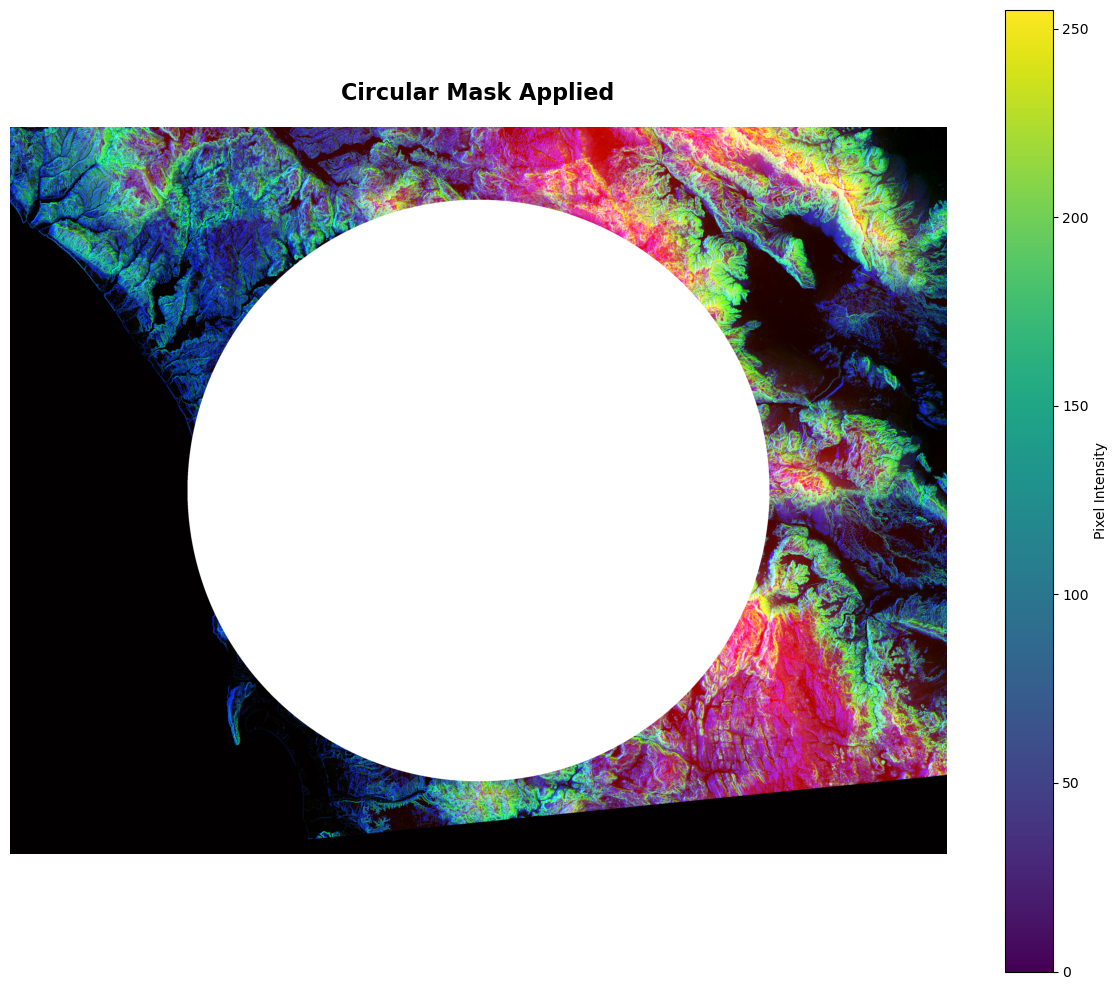

In [9]:
# Demonstrate advanced masking
print("\nCreating circular mask...")
circular_mask = processor.create_circular_mask()
processor.apply_mask(circular_mask, operation='highlight')
processor.display_image(title="Circular Mask Applied")

In [ ]:
# Example usage and demonstration
def main() -> None:
    """
    Main demonstration function showing professional usage patterns.
    """
    try:
        # Initialize processor with satellite image
        processor = SatelliteImageProcessor('sd-3layers.jpg')

        # Display basic image information
        print("\n" + "=" * 60)
        print("SATELLITE IMAGE PROCESSING PIPELINE")
        print("=" * 60)
        print(f"Image Shape: {processor.image_metadata['shape']}")
        print(f"Data Type: {processor.image_metadata['dtype']}")
        print(f"Value Range: [{processor.image_metadata['min_value']}, {processor.image_metadata['max_value']}]")
        print(f"File Size: {processor.image_metadata['size_mb']:.2f} MB")

        # Display original image
        processor.display_image(title="WIFIRE Satellite Image - Original")

        # Analyze individual topographic features
        print("\nAnalyzing topographic features...")
        processor.analyze_topographic_feature('altitude', threshold=160)
        processor.analyze_topographic_feature('slope', threshold=140)
        processor.analyze_topographic_feature('aspect', threshold=120)

        # Perform composite analysis
        print("\nPerforming composite analysis...")
        composite_thresholds = {
            'altitude': 150,
            'slope': 130,
            'aspect': 110
        }
        processor.generate_composite_analysis(composite_thresholds)

        # Demonstrate advanced masking
        print("\nCreating circular mask...")
        circular_mask = processor.create_circular_mask()
        processor.apply_mask(circular_mask, operation='highlight')
        processor.display_image(title="Circular Mask Applied")

        # Save processed results
        processor.save_processed_image('output/processed_satellite_image.tiff')

        print("\n" + "=" * 60)
        print("PROCESSING COMPLETE")
        print("=" * 60)

    except Exception as e:
        print(f"❌ Error in processing pipeline: {str(e)}")
        raise


if __name__ == "__main__":
    # Execute main pipeline
    main()